In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/碩一下/Machine Learning/Homework_4') 
os.listdir() 

['ieee-fraud-detection', 'Kaggle_4.ipynb', '0001.model']

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.ensemble import RandomForestClassifier
import time
import xgboost as xgb
import warnings
import pickle

In [4]:
train_id = pd.read_csv('ieee-fraud-detection/train_identity.csv')
train_tr = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
test_id = pd.read_csv('ieee-fraud-detection/test_identity.csv')
test_tr = pd.read_csv('ieee-fraud-detection/test_transaction.csv')

In [5]:
print(train_id.info())
print(train_tr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [6]:
train_id.head(2)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device


In [7]:
train_tr.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# 合併檔案
train = pd.merge(train_tr, train_id, how='left', 
                 on='TransactionID', left_index=True, 
                right_index=True)

In [9]:
test = pd.merge(test_tr, test_id, how='left',
               on='TransactionID', left_index=True,
               right_index=True)

In [10]:
print(train.shape)
print(test.shape)

(590540, 434)
(506691, 433)


In [11]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,74926.000000,140978.000000,127320.000000,80044.000000,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,231.855423,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,...,13.103775,9.184612,0.058494,0.851040,0.296633,0.336790,1.312844,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,-0.301124,99.745325,48.053071,-344.507146,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,529.053494,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,...,106.739813,73.627893,0.304415,3.950295,1.364356,1.580144,8.769083,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,2.789446,1.127602,11.774858,93.695502,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,-100.000000,90.000000,10.000000,-660.000000,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+0

In [12]:
test.describe()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,...,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-13,id-14,id-17,id-18,id-19,id-20,id-21,id-22,id-24,id-25,id-26,id-32
count,5.066910e+05,5.066910e+05,506691.000000,506691.000000,498037.000000,503689.000000,502144.000000,441082.000000,441082.000000,215474.000000,36436.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,506688.000000,501943.000000,506688.000000,500660.000000,271922.000000,303549.000000,429840.000000,282316.000000,124783.000000,60133.000000,74338.000000,74338.000000,494146.000000,330173.000000,69254.000000,123384.000000,115194.000000,494622.000000,...,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,7.643100e+04,7.643100e+04,7.643100e+04,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,76431.000000,141907.000000,136976.000000,66481.000000,66481.000000,134750.000000,134750.000000,5059.000000,5059.000000,74338.000000,74338.000000,136778.000000,130286.000000,71357.000000,135966.000000,50875.000000,135906.000000,135633.000000,5059.000000,5062.000000,4740.000000,5039.000000,5047.000000,70671.000000
mean,3.916894e+06,2.692994e+07,134.725568,9957.222175,363.735379,153.543409,200.162975,291.846514,86.723412,87.065270,237.175047,10.093211,10.714635,0.027403,2.385875,4.962701,6.854992,1.678173,1.893994,4.611943,1.810149,7.484594,2.649486,27.816035,6.083890,108.207504,188.666621,33.394727,175.060799,50.977752,82.443145,61.815642,160.834483,0.553981,159.810552,218.414895,77.404179,18.225961,58.163186,206.854137,...,1.216182,0.693514,0.047926,0.482658,0.163271,0.220486,0.460572,0.309900,3.151286e+02,4.404643e+02,3.811021e+02,24.708030,58.339468,35.485643,99.058760,155.578153,139.814706,-11.325734,192658.729909,0.053008,-0.087454,1.246033,-6.803829,12.493180,-36.577782,0.076219,-0.245877,99.750876,36.905715,-344.482672,191.070341,14.795735,350.122982,408.886230,507.727021,15.336823,13.166667,332.043064,152.752923,26.217939
std,1.462692e+05,4.756507e+06,245.779822,4884.960969,158.688653,12.443013,40.562461,102.062730,2.987328,314.131694,556.450834,79.334782,88.896921,0.227753,41.942977,25.462195,46.783565,37.874827,26.766115,21.282640,23.692393,61.322505,53.973060,101.114033,28.315616,176.964526,197.099611,82.558210,250.417470,116.829786,192.867671,150.299612,257.003738,0.317327,240.566557,253.091693,176.218548,78.079890,164.015525,269.419196,...,5.925144,3.343788,0.282497,2.555532,0.850853,1.789616,4.228813,2.632181,9.494045e+03,1.064843e+04,1.039556e+04,842.913287,990.361078,904.093921,2436.074522,4544.303974,4493.728267,14.508520,182613.277215,0.684551,0.840351,5.071394,15.921457,11.678206,25.544185,1.009687,2.120525,1.119819,13.206713,93.633156,30.749535,2.318496,139.140824,158.971756,227.371061,5.618032,3.222440,86.356683,31.916995,3.601046
min,3.663549e+06,1.840322e+07,0.018000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,2.000000,-12.000000,-19.000000,-81.000000,-100.000000,-41.000000,-100.000000,-32.000000,-100.000000,90.000000,11.000000,-720.000000,100.000000,11.000000,100.000000,100.000000,100.000000,11.000000,10.000000,100.000000,100.000000,8.000000
25%,3.790222e+06,2.277154e

In [13]:
target = train['isFraud']
target

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64

In [14]:
# 看看train和test有哪些不同的columns
def differentcolumns(traincols, testcols):
    for i in traincols:
        if i not in testcols:
            print(i)
differentcolumns(train.columns, test.columns)

isFraud
id_01
id_02
id_03
id_04
id_05
id_06
id_07
id_08
id_09
id_10
id_11
id_12
id_13
id_14
id_15
id_16
id_17
id_18
id_19
id_20
id_21
id_22
id_23
id_24
id_25
id_26
id_27
id_28
id_29
id_30
id_31
id_32
id_33
id_34
id_35
id_36
id_37
id_38


In [15]:
# 把test中的 - 改成 _ 讓columns一致
test = test.rename(columns={"id-01": "id_01", "id-02": "id_02", "id-03": "id_03", 
                            "id-06": "id_06", "id-05": "id_05", "id-04": "id_04", 
                            "id-07": "id_07", "id-08": "id_08", "id-09": "id_09", 
                            "id-10": "id_10", "id-11": "id_11", "id-12": "id_12", 
                            "id-15": "id_15", "id-14": "id_14", "id-13": "id_13", 
                            "id-16": "id_16", "id-17": "id_17", "id-18": "id_18", 
                            "id-21": "id_21", "id-20": "id_20", "id-19": "id_19", 
                            "id-22": "id_22", "id-23": "id_23", "id-24": "id_24", 
                            "id-27": "id_27", "id-26": "id_26", "id-25": "id_25", 
                            "id-28": "id_28", "id-29": "id_29", "id-30": "id_30", 
                            "id-31": "id_31", "id-32": "id_32", "id-33": "id_33", 
                            "id-34": "id_34", "id-35": "id_35", "id-36": "id_36", 
                            "id-37": "id_37", "id-38": "id_38"})
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


miss value 處理

In [16]:
train.isnull().sum().sum()

115523073

In [17]:
train.isnull().count()

TransactionID     590540
isFraud           590540
TransactionDT     590540
TransactionAmt    590540
ProductCD         590540
                   ...  
id_36             590540
id_37             590540
id_38             590540
DeviceType        590540
DeviceInfo        590540
Length: 434, dtype: int64

In [18]:
def getnulls(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['total', 'precent'])
    return missing_data

In [19]:
# Train Data Missing Values
missing_data_train = getnulls(train)
missing_data_train.head(350).T

,id_24,id_25,id_07,id_08,id_21,id_26,id_22,id_23,id_27,dist2,D7,id_18,D13,D14,D12,id_04,id_03,D6,id_33,id_10,D8,D9,id_09,id_30,id_32,id_34,id_14,V149,V153,V156,V154,V155,V157,V158,V161,V163,V147,V148,V162,V146,...,V16,V15,V13,V29,V12,V32,V33,V34,V28,D10,addr2,addr1,card2,card5,card4,card6,card3,V314,V313,V283,D1,V282,V288,V289,V315,V296,V300,V301,V281,V95,V96,V106,V114,V113,V112,V111,V110,V109,V108,V107
total,585793.000000,585408.00000,585385.000000,585385.000000,585381.000000,585377.000000,585371.000000,585371.000000,585371.000000,552913.000000,551623.000000,545427.000000,528588.000000,528353.000000,525823.00000,524216.000000,524216.000000,517353.000000,517251.000000,515614.000000,515614.000000,515614.000000,515614.000000,512975.000000,512954.000000,512735.000000,510496.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,508595.000000,...,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76022.000000,65706.000000,65706.000000,8933.000000,4259.000000,1577.00000,1571.00000,1565.00000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
precent,0.991962,0.99131,0.991271,0.991271,0.991264,0.991257,0.991247,0.991247,0.991247,0.936284,0.934099,0.923607,0.895093,0.894695,0.89041,0.887689,0.887689,0.876068,0.875895,0.873123,0.873123,0.873123,0.873123,0.868654,0.868619,0.868248,0.864456,0.861237,0.861237,0.861237,0.861237,0.861237,0.861237,0.861237,0.861237,0.861237,0.861237,0.861237,0.861237,0.861237,...,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128733,0.111264,0.111264,0.015127,0.007212,0.00267,0.00266,0.00265,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532


In [20]:
# Test Data Missing Values
missing_data_test = getnulls(test)
missing_data_test .head(350).T

,id_24,id_25,id_26,id_07,id_08,id_21,id_27,id_22,id_23,dist2,id_18,D7,id_04,id_03,D12,id_30,id_32,id_33,id_14,id_34,id_09,D9,id_10,D8,V153,V157,V154,V155,V156,V158,V148,V161,V162,V163,V149,V147,V146,V138,V139,V140,...,V90,V89,V87,V78,V86,V85,V84,V82,V80,V79,V83,D15,card2,D1,V301,V300,V296,V289,V288,V283,V282,V281,V314,V315,V313,C13,card5,card4,card6,card3,C2,C9,V292,V291,V290,C10,V286,V287,V294,V285
total,501951.000000,501652.000000,501644.000000,501632.000000,501632.000000,501632.000000,501629.00000,501629.00000,501629.00000,470255.00000,455816.000000,446558.000000,440210.000000,440210.000000,437437.000000,436032.000000,436020.000000,436020.000000,435334.000000,434516.000000,432353.000000,432353.000000,432353.000000,432353.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,430906.000000,...,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12069.000000,8654.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,4748.000000,4547.000000,3086.00000,3007.000000,3002.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
precent,0.990645,0.990055,0.990039,0.990016,0.990016,0.990016,0.99001,0.99001,0.99001,0.92809,0.899594,0.881322,0.868794,0.868794,0.863321,0.860548,0.860524,0.860524,0.859171,0.857556,0.853287,0.853287,0.853287,0.853287,0.850432,0.850432,0.850432,0.850432,0.850432,0.850432,0.850432,0.850432,0.850432,0.850432,0.850432,0.850432,0.850432,0.850432,0.850432,0.850432,...,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023819,0.017079,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.009371,0.008974,0.00609,0.005935,0.005925,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006


In [21]:
# Get the columns that we have to drop
# 把missing data佔太多的columns刪掉
droppedcols = missing_data_train[missing_data_train['total'] > 100000].index
droppedcols

Index(['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_22', 'id_23',
       'id_27', 'dist2',
       ...
       'V43', 'V49', 'V41', 'V40', 'V39', 'V38', 'V37', 'V36', 'V35', 'D4'],
      dtype='object', length=252)

In [22]:
# Drop the columns
train.drop(droppedcols, axis=1, inplace=True)
test.drop(droppedcols, axis=1, inplace=True)

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 182 entries, TransactionID to V321
dtypes: float64(174), int64(4), object(4)
memory usage: 820.0+ MB


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 181 entries, TransactionID to V321
dtypes: float64(174), int64(3), object(4)
memory usage: 699.7+ MB


In [25]:
print(train.shape)
print(test.shape)

(590540, 182)
(506691, 181)


In [26]:
# 看看現在missing data的狀況
missing_data_train = getnulls(train)
missing_data_train.head(200).T

,P_emaildomain,V89,V75,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V90,V91,V92,V93,V76,V94,D15,V69,V70,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,...,V306,V305,V309,V303,V304,V299,V291,V280,V284,V285,V286,V287,V290,V298,V310,V292,V293,V294,V295,V297,TransactionDT,ProductCD,card1,isFraud,TransactionAmt,C12,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C13,C14,TransactionID
total,94456.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89113.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,...,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.159949,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150901,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,...,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
missing_data_test = getnulls(test)
missing_data_test.head(200).T

,P_emaildomain,addr2,addr1,V71,V70,V69,V68,V67,V66,V65,V58,V63,V64,V73,V62,V61,V60,V59,V53,V54,V55,V56,V72,V57,V74,V16,V18,V20,V21,V22,V23,V25,V26,V27,V28,V29,V30,V31,V32,V33,...,V133,V95,V104,V111,V110,V109,V108,V107,V106,V105,V103,V113,V102,V101,V100,V99,V98,V97,V96,V112,V114,V132,V124,V131,V130,V129,V128,V127,V126,V125,V123,V115,V122,V121,V120,V119,V118,V117,V116,TransactionID
total,69192.000000,65609.000000,65609.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.136557,0.129485,0.129485,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# 看看emaildomain
train['P_emaildomain']

0                 NaN
1           gmail.com
2         outlook.com
3           yahoo.com
4           gmail.com
             ...     
590535            NaN
590536      gmail.com
590537      gmail.com
590538        aol.com
590539      gmail.com
Name: P_emaildomain, Length: 590540, dtype: object

In [29]:
train['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
windstream.net         305
roadrunner.com         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
twc.com                230
n

In [30]:
target.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [31]:
# 數看看mail有沒有特殊的型態
cntgmail = 0
cntyahoo = 0
cnthotmail = 0
cntanon = 0
cntaol = 0
for i in range(train.shape[0]):
    if train['P_emaildomain'][i] == 'gmail.com' and train['isFraud'][i] == 1:
        cntgmail += 1
    elif train['P_emaildomain'][i] == 'yahoo.com' and train['isFraud'][i] == 1:
        cntyahoo += 1
    elif train['P_emaildomain'][i] == 'hotmail.com' and train['isFraud'][i] == 1:
        cnthotmail += 1
    elif train['P_emaildomain'][i] == 'anonymous.com' and train['isFraud'][i] == 1:
        cntanon += 1
    elif train['P_emaildomain'][i] == 'aol.com' and train['isFraud'][i] == 1:
        cntaol += 1
    
print("GMAIL:", cntgmail)
print("YAHOO:", cntyahoo)
print("HOTMAIL:", cnthotmail)
print("ANON:", cntanon)
print("AOL:", cntaol)

GMAIL: 9943
YAHOO: 2297
HOTMAIL: 2396
ANON: 859
AOL: 617


In [32]:
# 好像沒有什麼特殊的，所以先drop這一行
train.drop(['P_emaildomain'], axis=1, inplace=True)
test.drop(['P_emaildomain'], axis=1, inplace=True)

In [33]:
print(train.shape)
print(test.shape)

(590540, 181)
(506691, 180)


In [34]:
missing_data_train = getnulls(train)
missing_data_train.head(100).T

,V90,V84,V77,V78,V79,V80,V81,V82,V83,V85,V75,V86,V87,V88,V89,V91,V92,V93,V76,V94,D15,V70,V62,V53,V54,V55,V56,V57,V58,V59,V60,V61,V63,V71,V64,V65,V66,V67,V68,V69,...,V16,V14,V13,V12,V29,V26,D10,addr2,addr1,card2,card5,card4,card6,card3,V288,V283,V282,V281,V300,V289,V296,V301,D1,V313,V314,V315,V134,V137,V133,V114,V135,V117,V118,V119,V120,V121,V122,V123,V124,V125
total,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89164.000000,89113.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,77096.000000,...,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76073.000000,76022.000000,65706.000000,65706.000000,8933.000000,4259.000000,1577.00000,1571.00000,1565.00000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
precent,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150987,0.150901,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,0.130552,...,0.128819,0.128819,0.128819,0.128819,0.128819,0.128819,0.128733,0.111264,0.111264,0.015127,0.007212,0.00267,0.00266,0.00265,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532


In [35]:
missing_data_test = getnulls(test)
missing_data_test.head(100).T

,addr2,addr1,V63,V71,V70,V69,V68,V67,V66,V65,V58,V64,V73,V62,V61,V60,V59,V53,V54,V55,V56,V72,V57,V74,V16,V18,V20,V21,V22,V23,V24,V26,V27,V28,V29,V30,V31,V32,V33,V34,...,V79,V86,V89,V75,V92,V90,V80,V81,D15,card2,V282,V283,V288,V289,D1,V313,V296,V314,V315,V300,V301,V281,C13,card5,card4,card6,card3,C2,C1,C7,C3,C4,C5,C6,C9,C10,C11,C12,C14,C8
total,65609.000000,65609.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12899.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,12589.000000,...,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12081.000000,12069.000000,8654.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,4748.000000,4547.000000,3086.00000,3007.000000,3002.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
precent,0.129485,0.129485,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.025457,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,0.024846,...,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023843,0.023819,0.017079,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.009371,0.008974,0.00609,0.005935,0.005925,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006


In [36]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,13.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,315.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,84.0,111.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can not figure out some pattern in this floating number columns cuz it has no meaning for us, so let's get rid of some of them and replace the nulls at others.

In [37]:
droppedcols = missing_data_train[missing_data_train['total'] > 15000].index

In [38]:
train.drop(droppedcols, axis=1, inplace=True)
test.drop(droppedcols, axis=1, inplace=True)
print(train.shape)
print(test.shape)

(590540, 112)
(506691, 111)


In [39]:
differentcolumns(train.columns, test.columns)

isFraud


In [40]:
missing_data_train = getnulls(train)
missing_data_train.head(100).T

,card2,card5,card4,card6,card3,V283,V282,V300,V301,V289,V288,V281,D1,V313,V314,V315,V296,V133,V117,V118,V137,V136,V135,V134,V124,V132,V131,V130,V116,V128,V127,V126,V125,V119,V123,V122,V129,V111,V115,V114,...,V321,V320,V302,V319,V318,V317,V316,V312,V279,V310,V309,V308,V307,V306,V305,V304,V303,V311,V299,V280,V297,V295,V294,V293,V292,V291,V290,V287,V286,V298,V285,V284,TransactionDT,card1,ProductCD,TransactionAmt,C2,isFraud,C1,C6
total,8933.000000,4259.000000,1577.00000,1571.00000,1565.00000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,...,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,12.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.015127,0.007212,0.00267,0.00266,0.00265,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.002149,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,0.000532,...,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
missing_data_test = getnulls(test)
missing_data_test.head(100).T

,card2,V283,V314,V296,V300,V289,V313,V281,V315,V288,V282,D1,V301,C13,card5,card4,card6,card3,V280,V279,C1,C3,C2,V285,V320,C4,C5,C6,C7,C8,C9,C10,C11,C12,C14,V284,V321,V286,V302,V319,...,V294,V295,V297,card1,ProductCD,TransactionAmt,TransactionDT,V103,V95,V96,V97,V98,V99,V100,V101,V102,V125,V104,V130,V123,V124,V126,V127,V128,V129,V131,V105,V132,V133,V134,V135,V136,V137,V122,V121,V120,V119,V118,V117,V116
total,8654.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,6031.000000,4748.000000,4547.000000,3086.00000,3007.000000,3002.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
precent,0.017079,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.011903,0.009371,0.008974,0.00609,0.005935,0.005925,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Concatinating all data to fill the null values with the mean and mode

In [42]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train, test], axis=0, sort=False)
all_data.shape

(1097231, 112)

In [43]:
ntrain + ntest

1097231

In [44]:
# 填入missing values(object)
all_data_cols = all_data.columns
for i in all_data_cols:
    if all_data[i].dtype == 'object':
        all_data[i] = all_data[i].fillna(all_data[i].mode()[0])

In [45]:
missing_data = getnulls(all_data)
missing_data.head(110).T

,isFraud,card2,card5,V283,D1,V300,V301,V289,V288,V282,V281,V313,V314,V315,V296,C13,card3,V133,V117,V118,V137,V136,V135,V134,V124,V132,V131,V130,V116,V128,V127,V126,V125,V119,V123,V122,V129,V111,V115,V114,...,V309,V308,V307,V306,V305,V304,V303,V311,V299,V291,V286,V285,V284,V287,V290,V280,V292,V293,V294,V295,V297,V298,C4,C1,C2,C3,C6,C5,C7,C8,C9,C10,C11,C12,C14,card6,card4,card1,ProductCD,TransactionAmt
total,506691.000000,17587.000000,8806.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,7300.000000,4748.000000,4567.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0
precent,0.461791,0.016029,0.008026,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.006653,0.004327,0.004162,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,0.000286,...,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.0,0.0,0.0,0.0,0.0


In [46]:
all_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# 填入missing values / 看看填完還有哪些missing values
for i in all_data_cols:
    if (i.startswith("C") or (i.startswith("V"))) and all_data[i].isnull().sum() > 0:
        all_data[i] = all_data[i].fillna(all_data[i].mode()[0])
missing_data = getnulls(all_data)
missing_data.head(10).T

,isFraud,card2,card5,D1,card3,V109,V108,V107,V106,V105
total,506691.000000,17587.000000,8806.000000,7300.000000,4567.000000,0.0,0.0,0.0,0.0,0.0
precent,0.461791,0.016029,0.008026,0.006653,0.004162,0.0,0.0,0.0,0.0,0.0


In [48]:
all_data['card3'].value_counts()

150.0    956845
185.0    109960
106.0      3543
117.0      2841
144.0      2633
          ...  
172.0         1
221.0         1
178.0         1
139.0         1
232.0         1
Name: card3, Length: 133, dtype: int64

In [49]:
all_data['D1'].value_counts()

0.0      507854
1.0       16887
2.0        9974
3.0        8038
4.0        6965
          ...  
557.0       278
593.0       276
591.0       273
640.0        67
641.0         1
Name: D1, Length: 642, dtype: int64

In [50]:
all_data['D1'] = all_data['D1'].fillna(all_data['D1'].mode()[0])
all_data['card3'] = all_data['card3'].fillna(all_data['card3'].mean())

In [51]:
all_data['card2'].value_counts()

321.0    91731
111.0    82537
555.0    80404
490.0    70496
583.0    41503
         ...  
293.0      126
419.0      126
121.0      126
552.0      125
487.0      123
Name: card2, Length: 501, dtype: int64

In [52]:
all_data['card2'] = all_data['card2'].fillna(all_data['card2'].mean())

In [53]:
missing_data = getnulls(all_data)
missing_data.head(5).T

,isFraud,card5,V321,V110,V99
total,506691.000000,8806.000000,0.0,0.0,0.0
precent,0.461791,0.008026,0.0,0.0,0.0


In [54]:
all_data['card5'].value_counts()

226.0    553537
224.0    153109
166.0    102930
102.0     49491
117.0     47061
          ...  
221.0         1
175.0         1
208.0         1
124.0         1
209.0         1
Name: card5, Length: 138, dtype: int64

In [55]:
all_data['card5'] = all_data['card5'].fillna(all_data['card5'].mean())

In [56]:
missing_data = getnulls(all_data)
missing_data.head(5).T

,isFraud,V321,V110,V99,V100
total,506691.000000,0.0,0.0,0.0,0.0
precent,0.461791,0.0,0.0,0.0,0.0


In [57]:
print(ntrain)
print(ntest)
print(ntrain+ntest)
print(all_data.shape)

590540
506691
1097231
(1097231, 112)


In [58]:
# Split the data again
train = all_data[:ntrain]
test = all_data[ntrain:]

In [59]:
# Encoding the data
all_data = pd.get_dummies(all_data)
print(all_data.shape)
all_data.head()

(1097231, 122)


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,2987000,0.0,86400,68.5,13926,363.099769,150.0,142.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0
1,2987001,0.0,86401,29.0,2755,404.000000,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,1,0,0
2,2987002,0.0,86469,59.0,4663,490.000000,150.0,166.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,2987003,0.0,86499,50.0,18132,567.000000,150.0,117.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0
4,2987004,0.0,86506,50.0,4497,514.000000,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [60]:
# Split the data again and get ready for training
train = all_data[:ntrain]
test = all_data[ntrain:]
train.drop(['TransactionID'], axis=1, inplace=True)
# test_id = test['TransactionID']
# test.drop(['TransactionID'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

(590540, 121)
(506691, 122)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [61]:
train.head(2)

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,...,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,0.0,86400,68.5,13926,363.099769,150.0,142.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0
1,0.0,86401,29.0,2755,404.000000,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,1,0,0


In [62]:
test.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,3663549,NaN,18403224,31.95,10409,111.0,150.0,226.0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,47.950001,0.0,0.0,47.950001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,3663550,NaN,18403263,49.00,4272,111.0,150.0,226.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,0.0,4.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,280.000000,77.0,0.0,280.000000,0.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0,0,1,0


In [63]:
target

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: int64

In [64]:
train.drop(['isFraud'], axis=1, inplace=True)
test.drop(['isFraud'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(590540, 120)
(506691, 121)


In [65]:
train.to_csv("ieee-fraud-detection/train.csv",index=False)
target.to_csv("ieee-fraud-detection/target.csv",index=False)
test.to_csv("ieee-fraud-detection/test.csv",index=False)

## 從這邊重新開始

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/碩一下/Machine Learning/Homework_4') 
os.listdir() 

['ieee-fraud-detection', 'Kaggle_4.ipynb', '0001.model']

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.ensemble import RandomForestClassifier
import time
import xgboost as xgb

In [4]:
train=pd.read_csv("ieee-fraud-detection/train.csv")
target=pd.read_csv("ieee-fraud-detection/target.csv")
test=pd.read_csv("ieee-fraud-detection/test.csv")

In [5]:
test_id = test['TransactionID']
test.drop(['TransactionID'], axis=1, inplace=True)

In [11]:
# XGBOOST
xgmodel = xgb.XGBClassifier(learning_rate=0.1, max_depth=16, 
                        n_estimators=200, random_state =13)

In [12]:
xgmodel.fit(train, target)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=16,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=13,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [13]:
y_pred_xg = xgmodel.predict_proba(test)

In [14]:
y_pred_xg

array([[9.9976867e-01, 2.3135111e-04],
       [9.9948835e-01, 5.1163253e-04],
       [9.9935430e-01, 6.4568064e-04],
       ...,
       [9.9453098e-01, 5.4690023e-03],
       [9.9705267e-01, 2.9473214e-03],
       [9.9549848e-01, 4.5015113e-03]], dtype=float32)

In [15]:
sub = pd.DataFrame()
sub['TransactionID'] = test_id
sub['isFraud'] = y_pred_xg[:, 1]
sub.to_csv('answer.csv', index=False)

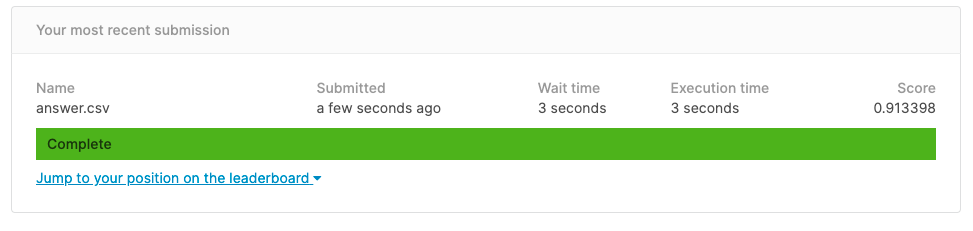

參考自：https://www.kaggle.com/kickitlikeshika/fraud-detection-with-92-acc